# Continuing on the Dask Data structures

Dask offers several pythonic data structures to handle and operate with larger-than-memory data in a distributed system.
- `dask.bag`: distributed generic python list. The Dask equivalent to a PySpark RDD
- `dask.array`: distributed numpy arrays
- `dask.dataframe`: distributed pandas dataframes

All the high-level data structure APIs are optimized to exploit the DAG optimization features of the Dask scheduler, and thus rely on lazy computation.

## Start the Dask cluster

In [1]:
from dask.distributed import Client

# use the provided master
client = Client('dask-scheduler:8786')
    
# print the status of the client        
client

<Client: 'tcp://172.25.0.2:8786' processes=3 threads=3, memory=1.43 GiB>

## Dask DataFrame

The `dask.dataframe` API implements a blocked parallel DataFrame object that mimics a large subset of the Pandas DataFrame interfaces.

A Dask DataFrame is comprised of many in-memory Pandas DataFrames or Series hosted on all machines of the cluster. A Dask DataFrame has its table separated (partitioned) along the index **\*** .

One operation on a Dask DataFrame triggers many Pandas operations on the constituent Pandas DataFrames in a way that is mindful of potential parallelism and memory constraints.

**\*** _Quick question: What kind of data partitioning are we referring to in this case? Vertical or Horizontal?_


### (On Data Partitioning)

Partitioning is one of the key aspects of data management and processing in distributed systems, including frameworks like Spark and Dask.

Distributing our dataset into a large number of small partitions enables parallel processing on each node. However, it's important to note that every call the central scheduler makes to access data on a remote partition (on a worker) incurs some time, typically in the order of a few hundred milliseconds.

As users of distributed processing systems, it is our responsibility (not Dask's or Spark's) to decide and optimize the number of partitions. The distributed framework may make an initial choice or guess, but optimizing performance depends on us making the right choice based on the task at hand.

For example, when initially loading data from a set of files, the number of partitions might be equal to the number of CSV files we are importing. However, as we modify the size of our DataFrames through filtering or joining, it may be wise to reconsider the number of partitions to optimize the Dask scheduler's overhead.

_There is always a cost associated with having too many or too few partitions, and unfortunately, there is no single rule to determine the "right" number of partitions._

As a _rule of thumb_, partitions should fit comfortably in memory. However, they should not be too numerous, as the overhead of the central scheduler can impact computation performance.

This means that the number of partitions should be in a "reasonable range," and their number and size should be chosen by the user to optimize execution.

## Basic operations on DataFrames

Let's start by reading a set of structured files (comma-separated) into a DataFrame.

In pure Pandas, we would have to loop over all the files, open each one of them as a DataFrame, and concatenate all the DataFrames into a large DataFrame.

The resulting DataFrame is a single entity stored in memory, allowing for single-threaded data access.

In [2]:
! ls datasets/accounts_csv

accounts.0.csv	accounts.1.csv	accounts.2.csv


In [3]:
! head -10 datasets/accounts_csv/accounts.0.csv

In [4]:
# import the necessary libraries
from glob import iglob
import pandas as pd
import os

# define the path to the CSV files
path = os.path.join('datasets', 'accounts_csv', 'accounts.*.csv')

# use glob to find all matching file paths
all_files = iglob(path, recursive=True)

# create a generator to read each CSV file as a Pandas DataFrame
dataframes = (pd.read_csv(f) for f in all_files)

# concatenate all DataFrames into a single large DataFrame
large_dataframe = pd.concat(dataframes, ignore_index=True)

In [5]:
# print the pandas DataFrame
large_dataframe

id   names  amount
0          9   Wendy      15
1         15  Victor      77
2        381     Bob    3064
3        358  Ingrid    2041
4        299   Kevin     204
...      ...     ...     ...
2999995  331   Laura     528
2999996  350   Kevin    6062
2999997  174  Yvonne     205
2999998   73  Xavier   -1691
2999999  422   Wendy     795

[3000000 rows x 3 columns]

In Dask, DataFrames can be created from a glob pattern using the wildcard `*`, which reads all files in the specified path matching that pattern into the same Dask DataFrame.

It's important to remember that Dask DataFrames are a collection of Pandas DataFrames scattered across the workers.

When reading data into a Dask DataFrame, Dask automatically creates parallel jobs to read the data in parallel. By default, it creates one parallel job per chunk, which is typically the number of input files. However, it is recommended to consider how we want to partition our dataset to make the best use of our workers.

In [6]:
# import the necessary libraries
import dask.dataframe as dd

# define the path to the CSV files
path = os.path.join('datasets', 'accounts_csv', 'accounts.*.csv')

# read the CSV files into a Dask DataFrame
df = dd.read_csv(path)


As always, reading data is a lazy operation, meaning it is postponed until we have something to compute.

Let's compute the length of the entire DataFrame.

In [7]:
# compute the length of the Dask DataFrame
len(df)

3000000

At this stage, each file was loaded into a separate Pandas DataFrame and scattered across the nodes.

Computing `len()` means that `len` was applied to each individual Pandas DataFrame, and then the sub-results were aggregated and combined to provide the overall total length of the DataFrame.

In [8]:
# "print" the Dask DataFrame
df

Dask DataFrame Structure:
                  id   names amount
npartitions=3                      
               int64  object  int64
                 ...     ...    ...
                 ...     ...    ...
                 ...     ...    ...
Dask Name: read-csv, 1 graph layer

We can reassign the number of partitions to the Dask DataFrame object using the `repartition` method.

In [9]:
# change the number of partitions to 8
df = df.repartition(npartitions=8)

In [10]:
# "print" the Dask DataFrame
df

Dask DataFrame Structure:
                  id   names amount
npartitions=8                      
               int64  object  int64
                 ...     ...    ...
...              ...     ...    ...
                 ...     ...    ...
                 ...     ...    ...
Dask Name: repartition, 2 graph layers

In [11]:
# compute the length of the Dask DataFrame
len(df)

3000000

In [12]:
# compute the number of partitions of the Dask DataFrame
df.npartitions

8

It is worth mentioning that unlike Pandas, Dask only reads a sample from the beginning of the file (or the list of files) to start inferring the data types.

These inferred data types are then enforced when reading all partitions, which can potentially lead to incorrect data type assignments.

For example, consider the case where we start reading a CSV file in which the first $n$ entries of a column are all integers, but the column is actually supposed to be of type _string_.

In [13]:
# read CSV files - explicitely parse dates 
df = dd.read_csv(os.path.join('datasets', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})


In [14]:
# print the DataFrame dtypes
df.dtypes

Date                 datetime64[ns]
DayOfWeek                     int64
DepTime                     float64
CRSDepTime                    int64
ArrTime                     float64
CRSArrTime                    int64
UniqueCarrier                object
FlightNum                     int64
TailNum                     float64
ActualElapsedTime           float64
CRSElapsedTime                int64
AirTime                     float64
ArrDelay                    float64
DepDelay                    float64
Origin                       object
Dest                         object
Distance                    float64
TaxiIn                      float64
TaxiOut                     float64
Cancelled                     int64
Diverted                      int64
dtype: object

In [15]:
# the head of the *distributed* Dask DataFrame
df.head()

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
0 1993-01-29          5   1055.0        1055   1228.0        1212   
1 1993-01-30          6   1052.0        1055   1214.0        1212   
2 1993-01-31          7   1103.0        1055   1213.0        1212   
3 1993-01-03          7   1736.0        1729   1838.0        1831   
4 1993-01-04          1   1730.0        1729   1825.0        1831   

  UniqueCarrier  FlightNum  TailNum  ActualElapsedTime  ...  AirTime  \
0            US         66      NaN               93.0  ...      NaN   
1            US         66      NaN               82.0  ...      NaN   
2            US         66      NaN               70.0  ...      NaN   
3            US         70      NaN               62.0  ...      NaN   
4            US         70      NaN               55.0  ...      NaN   

   ArrDelay  DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  \
0      16.0       0.0     EWR  BUF    282.0     NaN      NaN          0   
1       2.0      -3.0     EWR  BUF    282.0     NaN      NaN          0   
2       1.0       8.0     EWR  BUF    282.0     NaN      NaN          0   
3       7.0       7.0     LGA  SYR    198.0     NaN      NaN          0   
4      -6.0       1.0     LGA  SYR    198.0     NaN      NaN          0   

   Diverted  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 21 columns]

In [16]:
# the tail of the *distributed* Dask DataFrame
df.tail()

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

In this case, the datatypes inferred for `CRSElapsedTime` and `TailNum` are in fact incorrect. 

However, we can force Dask to interpret the data types as we want by using the `dtype` assignment. This is usually the most viable and robust solution, but not the only one.

Alternatively, we could:
- Increase the size of the sample used to infer the data types.
- Use `assume_missing` to make Dask assume that columns inferred to be `int` (which don't allow missing values) are actually `floats` (which do allow missing values).

However, in general, the best solution is still to hard-code the data types.

In [17]:
# read CSV files with parsing dates and specifying data types
df = dd.read_csv(os.path.join('datasets', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float})

In [18]:
# repartition the dataframe
df = df.repartition(8)

In [19]:
# print the tail of the dataframe
df.tail()

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
269176 1999-12-27          1   1645.0        1645   1830.0        1901   
269177 1999-12-28          2   1726.0        1645   1928.0        1901   
269178 1999-12-29          3   1646.0        1645   1846.0        1901   
269179 1999-12-30          4   1651.0        1645   1908.0        1901   
269180 1999-12-31          5   1642.0        1645   1851.0        1901   

       UniqueCarrier  FlightNum TailNum  ActualElapsedTime  ...  AirTime  \
269176            UA       1753  N516UA              225.0  ...    205.0   
269177            UA       1753  N504UA              242.0  ...    214.0   
269178            UA       1753  N592UA              240.0  ...    220.0   
269179            UA       1753  N575UA              257.0  ...    233.0   
269180            UA       1753  N539UA              249.0  ...    232.0   

        ArrDelay  DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  \
269176     -31.0       0.0     LGA  DEN   1619.0     7.0     13.0          0   
269177      27.0      41.0     LGA  DEN   1619.0     5.0     23.0          0   
269178     -15.0       1.0     LGA  DEN   1619.0     5.0     15.0          0   
269179       7.0       6.0     LGA  DEN   1619.0     5.0     19.0          0   
269180     -10.0      -3.0     LGA  DEN   1619.0     6.0     11.0          0   

        Diverted  
269176         0  
269177         0  
269178         0  
269179         0  
269180         0  

[5 rows x 21 columns]

While on the topic of reading data from files, it is worth mentioning that Dask offers a wide range of APIs for importing structured data from various file formats into a DataFrame object, including:
- CSV
- JSON
- Avro
- Parquet

For a more extensive list, please refer to the official documentation at the following [link](https://docs.dask.org/en/stable/dataframe-create.html).

## Computations with Dask DataFrames

Dask DataFrames are designed to closely mimic the Pandas DataFrame API, with nearly a 1-to-1 correspondence. Dask provides a wrapper around the Pandas API to manage the same calls on the distributed collection of Pandas DataFrames, which in our case are the partitions of our dataset.

Using Dask DataFrames is beneficial when Pandas reaches its limits, such as when dealing with datasets larger than memory or tasks that can be efficiently parallelized.

However, when working with small datasets or tasks that are not easily parallelizable, Pandas will always be the better choice.

For this reason, the typical computing pattern when working with Dask DataFrames is as follows:
1. Use `Dask Bag` to ingest data from semi/unstructured sources and preprocess it into Dask DataFrames.
2. Use `Dask DataFrame` for parallel computations and data reduction to produce a slimmed-down DataFrame that can fit in memory. Then, convert it into a single Pandas DataFrame.
3. Use `Pandas` for simple (yet fast) DataFrame operations for non-parallelizable tasks.

We can always retrieve data from all partitions and create a Pandas DataFrame from a Dask DataFrame using the `compute` method on the DataFrame itself.

However, it's important to note that this operation should be done carefully and only at the appropriate time, especially when dealing with very large (possibly terabytes-sized) Dask DataFrames. It should only be performed when we have reduced the DataFrame to a manageable size that can fit into our computer's memory.

In [20]:
# convert Dask DataFrame to Pandas DataFrame
pandas_df = df.compute()

# display the Pandas DataFrame
pandas_df

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
0      1993-01-29          5   1055.0        1055   1228.0        1212   
1      1993-01-30          6   1052.0        1055   1214.0        1212   
2      1993-01-31          7   1103.0        1055   1213.0        1212   
3      1993-01-03          7   1736.0        1729   1838.0        1831   
4      1993-01-04          1   1730.0        1729   1825.0        1831   
...           ...        ...      ...         ...      ...         ...   
269176 1999-12-27          1   1645.0        1645   1830.0        1901   
269177 1999-12-28          2   1726.0        1645   1928.0        1901   
269178 1999-12-29          3   1646.0        1645   1846.0        1901   
269179 1999-12-30          4   1651.0        1645   1908.0        1901   
269180 1999-12-31          5   1642.0        1645   1851.0        1901   

       UniqueCarrier  FlightNum TailNum  ActualElapsedTime  ...  AirTime  \
0                 US         66     NaN               93.0  ...      NaN   
1                 US         66     NaN               82.0  ...      NaN   
2                 US         66     NaN               70.0  ...      NaN   
3                 US         70     NaN               62.0  ...      NaN   
4                 US         70     NaN               55.0  ...      NaN   
...              ...        ...     ...                ...  ...      ...   
269176            UA       1753  N516UA              225.0  ...    205.0   
269177            UA       1753  N504UA              242.0  ...    214.0   
269178            UA       1753  N592UA              240.0  ...    220.0   
269179            UA       1753  N575UA              257.0  ...    233.0   
269180            UA       1753  N539UA              249.0  ...    232.0   

        ArrDelay  DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  \
0           16.0       0.0     EWR  BUF    282.0     NaN      NaN          0   
1            2.0      -3.0     EWR  BUF    282.0     NaN      NaN          0   
2            1.0       8.0     EWR  BUF    282.0     NaN      NaN          0   
3            7.0       7.0     LGA  SYR    198.0     NaN      NaN          0   
4           -6.0       1.0     LGA  SYR    198.0     NaN      NaN          0   
...          ...       ...     ...  ...      ...     ...      ...        ...   
269176     -31.0       0.0     LGA  DEN   1619.0     7.0     13.0          0   
269177      27.0      41.0     LGA  DEN   1619.0     5.0     23.0          0   
269178     -15.0       1.0     LGA  DEN   1619.0     5.0     15.0          0   
269179       7.0       6.0     LGA  DEN   1619.0     5.0     19.0          0   
269180     -10.0      -3.0     LGA  DEN   1619.0     6.0     11.0          0   

        Diverted  
0              0  
1              0  
2              0  
3              0  
4              0  
...          ...  
269176         0  
269177         0  
269178         0  
269179         0  
269180         0  

[528060 rows x 21 columns]

Let's work with basic DataFrame operations and compare their impact in Dask vs Pandas.

In Dask, operations on columns and individual items are easily parallelized, making them very fast.

In [21]:
# retrieve the max of the DepDelay column
df.DepDelay.max().compute()

1435.0

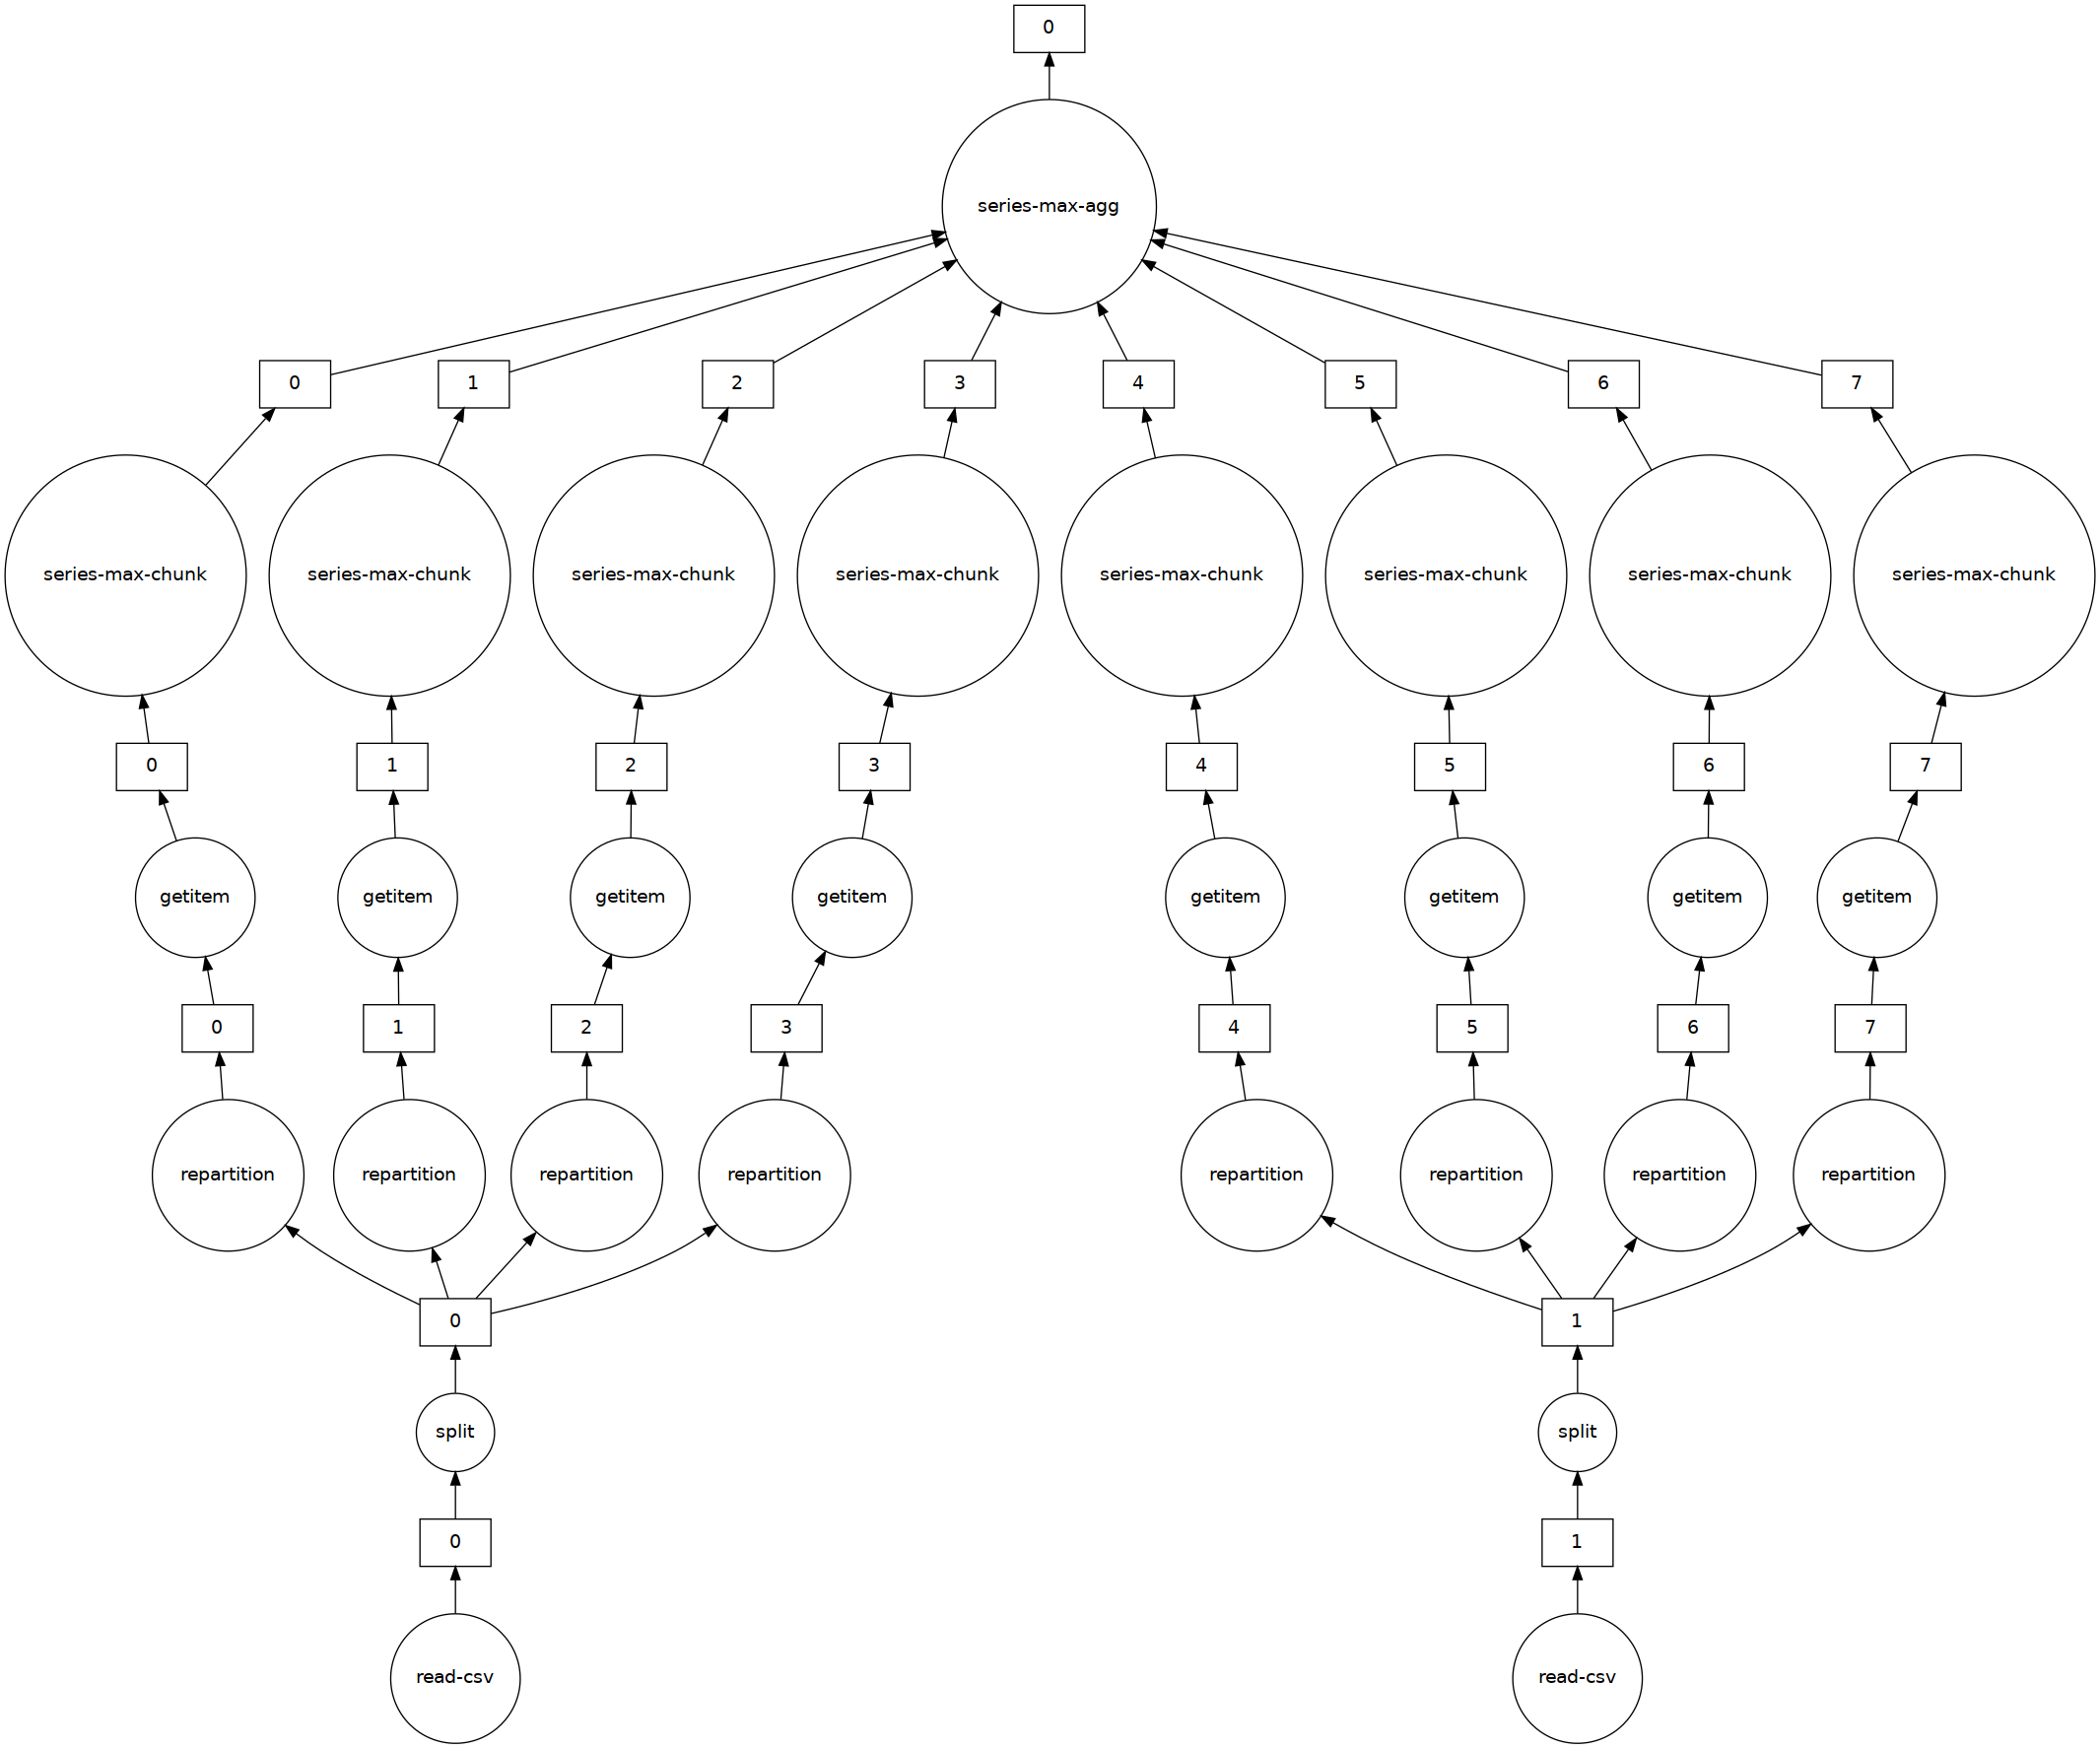

In [22]:
# visualize the graph for this operation
df.DepDelay.max().visualize()

In [23]:
# find the average arrival delay (ArrDelay) 
# of all flights with carrier UnitedAirlines (UA)
df[df.UniqueCarrier == 'UA'].ArrDelay.mean().compute()

7.602844406707705

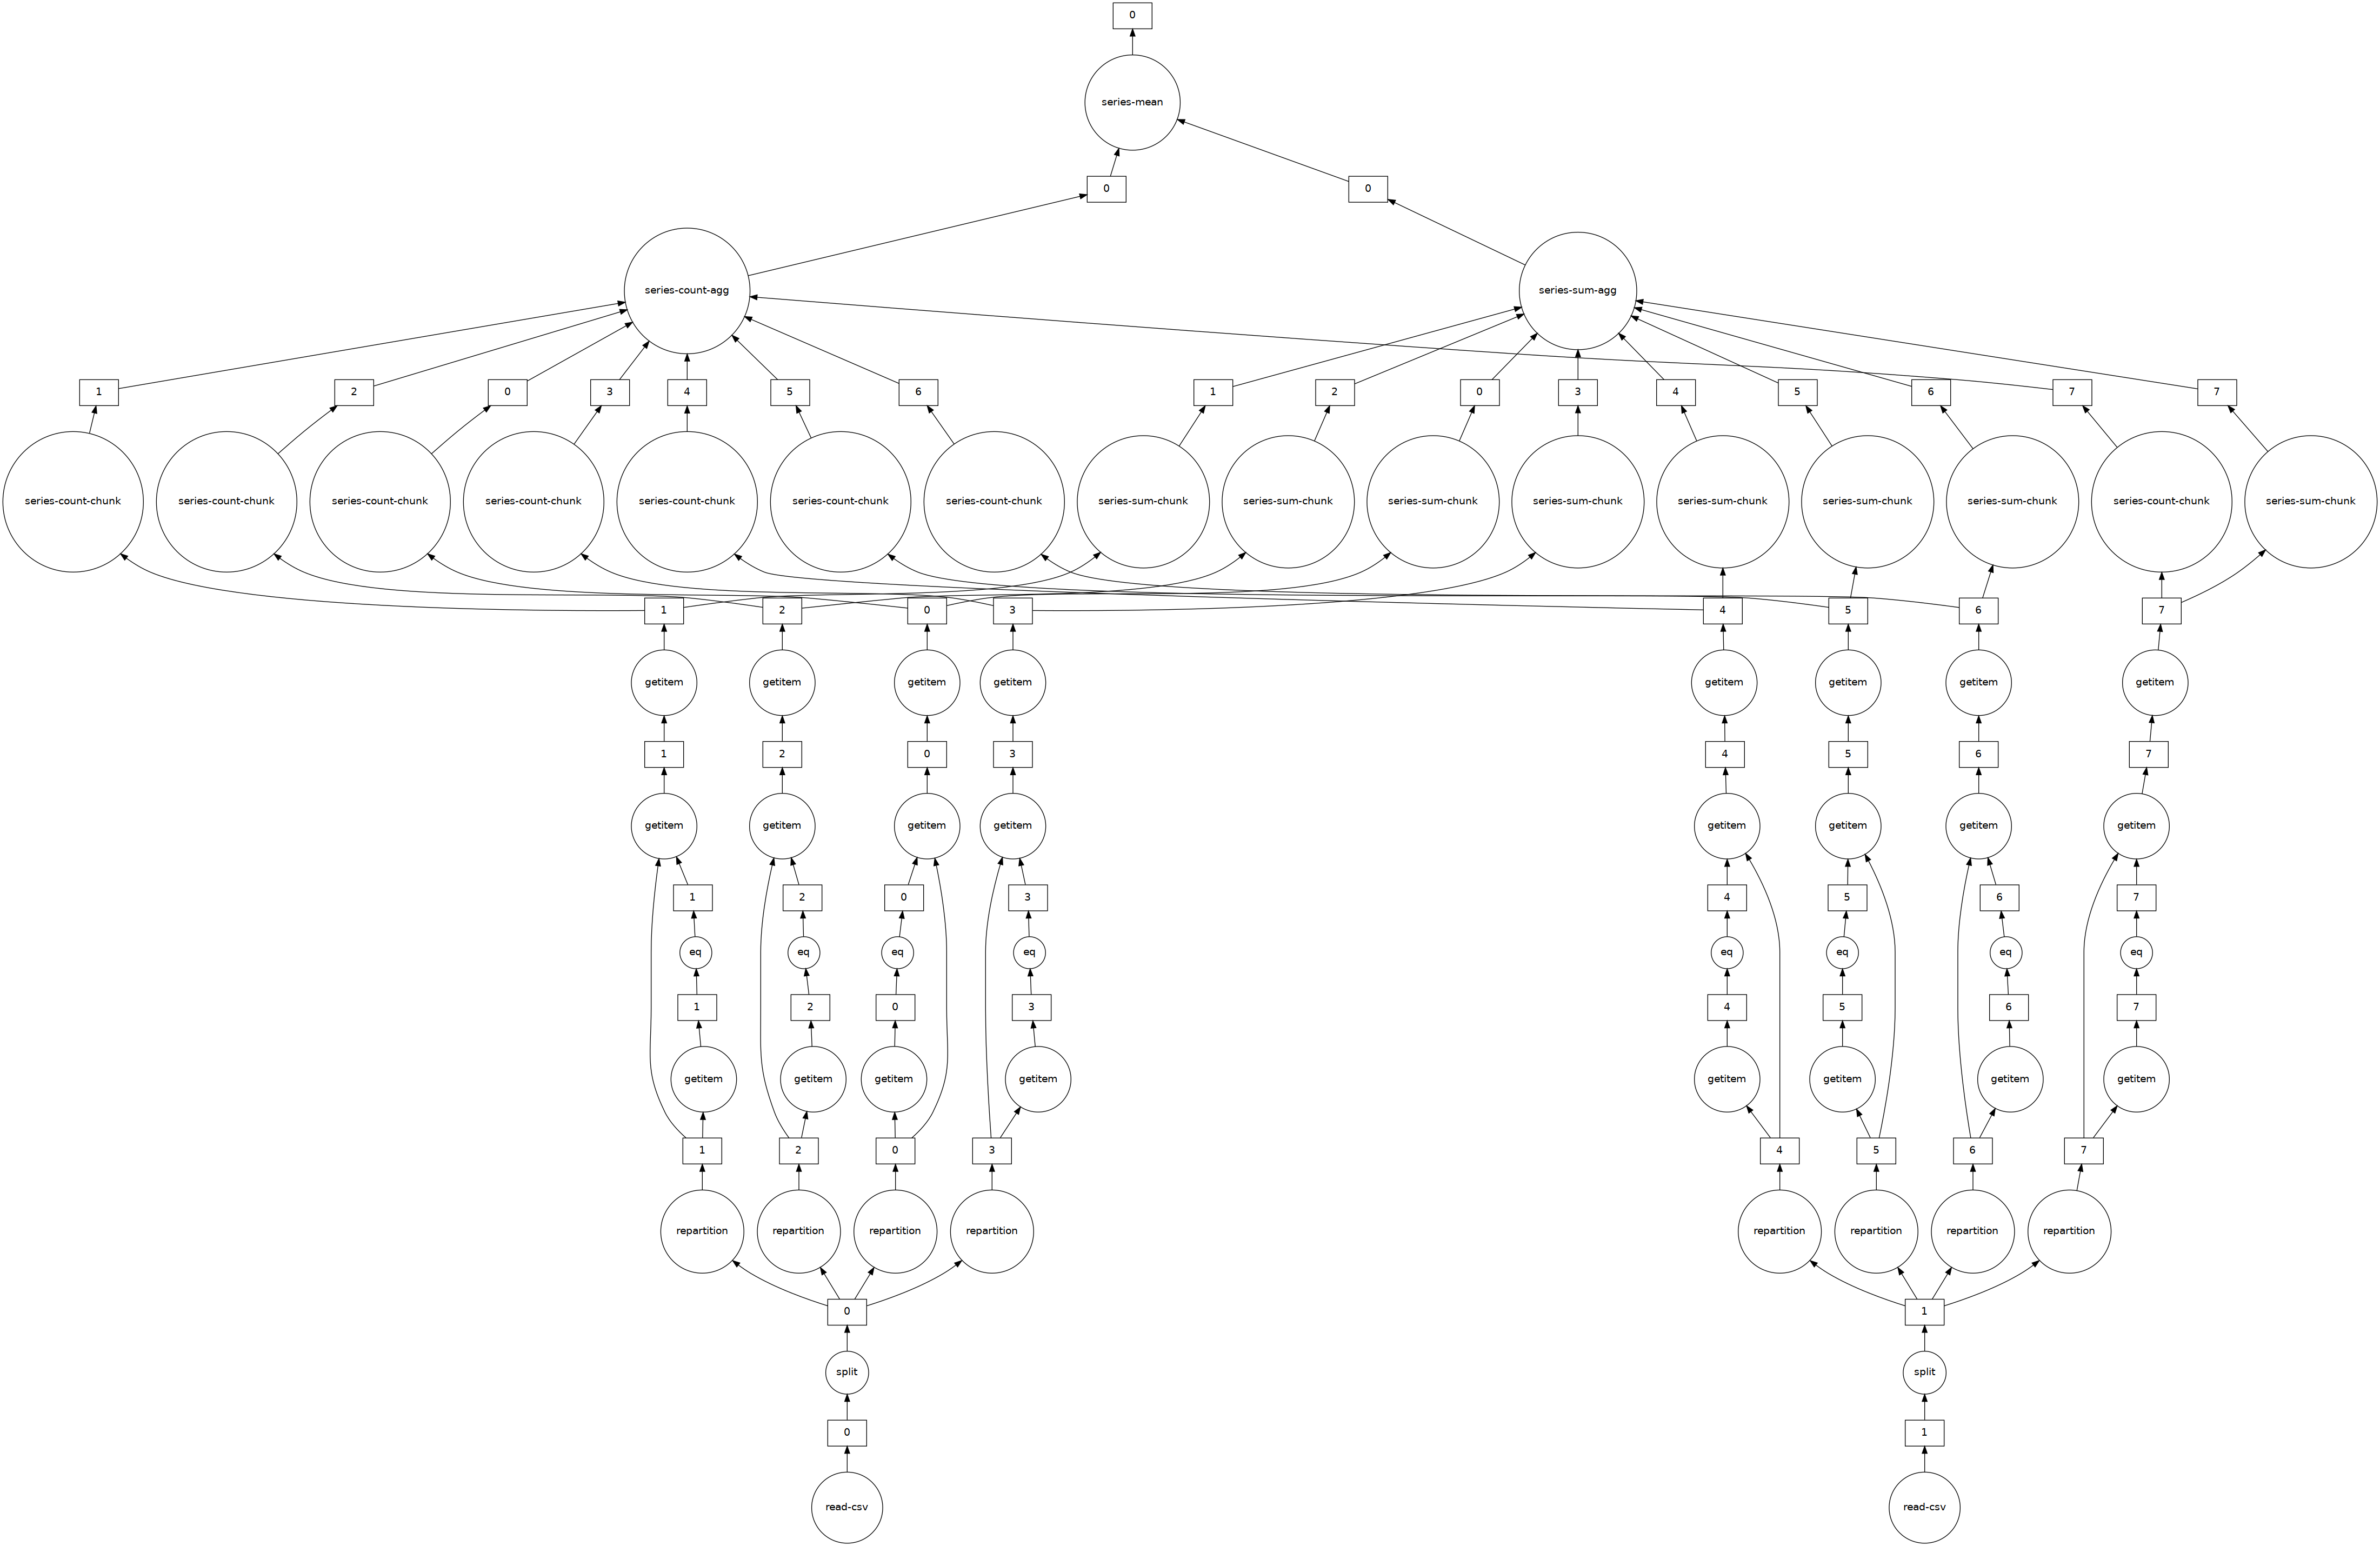

In [24]:
# visualize the graph for this last operation
df[df.UniqueCarrier == 'UA'].ArrDelay.mean().visualize()

Dask DataFrames also provide efficient implementations of operations that involve minimal shuffling, such as group-based aggregations and merge operations.

This means that operations like `groupby`, `resample`, `rolling`, and similar operations are still _reasonably_ fast, thanks to extensive under-the-hood optimizations.

In [26]:
# find the max airtime by combinations of origin and destination
df.groupby(['Origin', 'Dest']).AirTime.max().compute()

Origin  Dest
EWR     ATL     213.0
        BDL       NaN
        BNA     166.0
        BOS     180.0
        BTV       NaN
                ...  
LGA     HOU     294.0
EWR     SJC     377.0
LGA     LWB      84.0
EWR     SAV     118.0
        TUS     297.0
Name: AirTime, Length: 175, dtype: float64

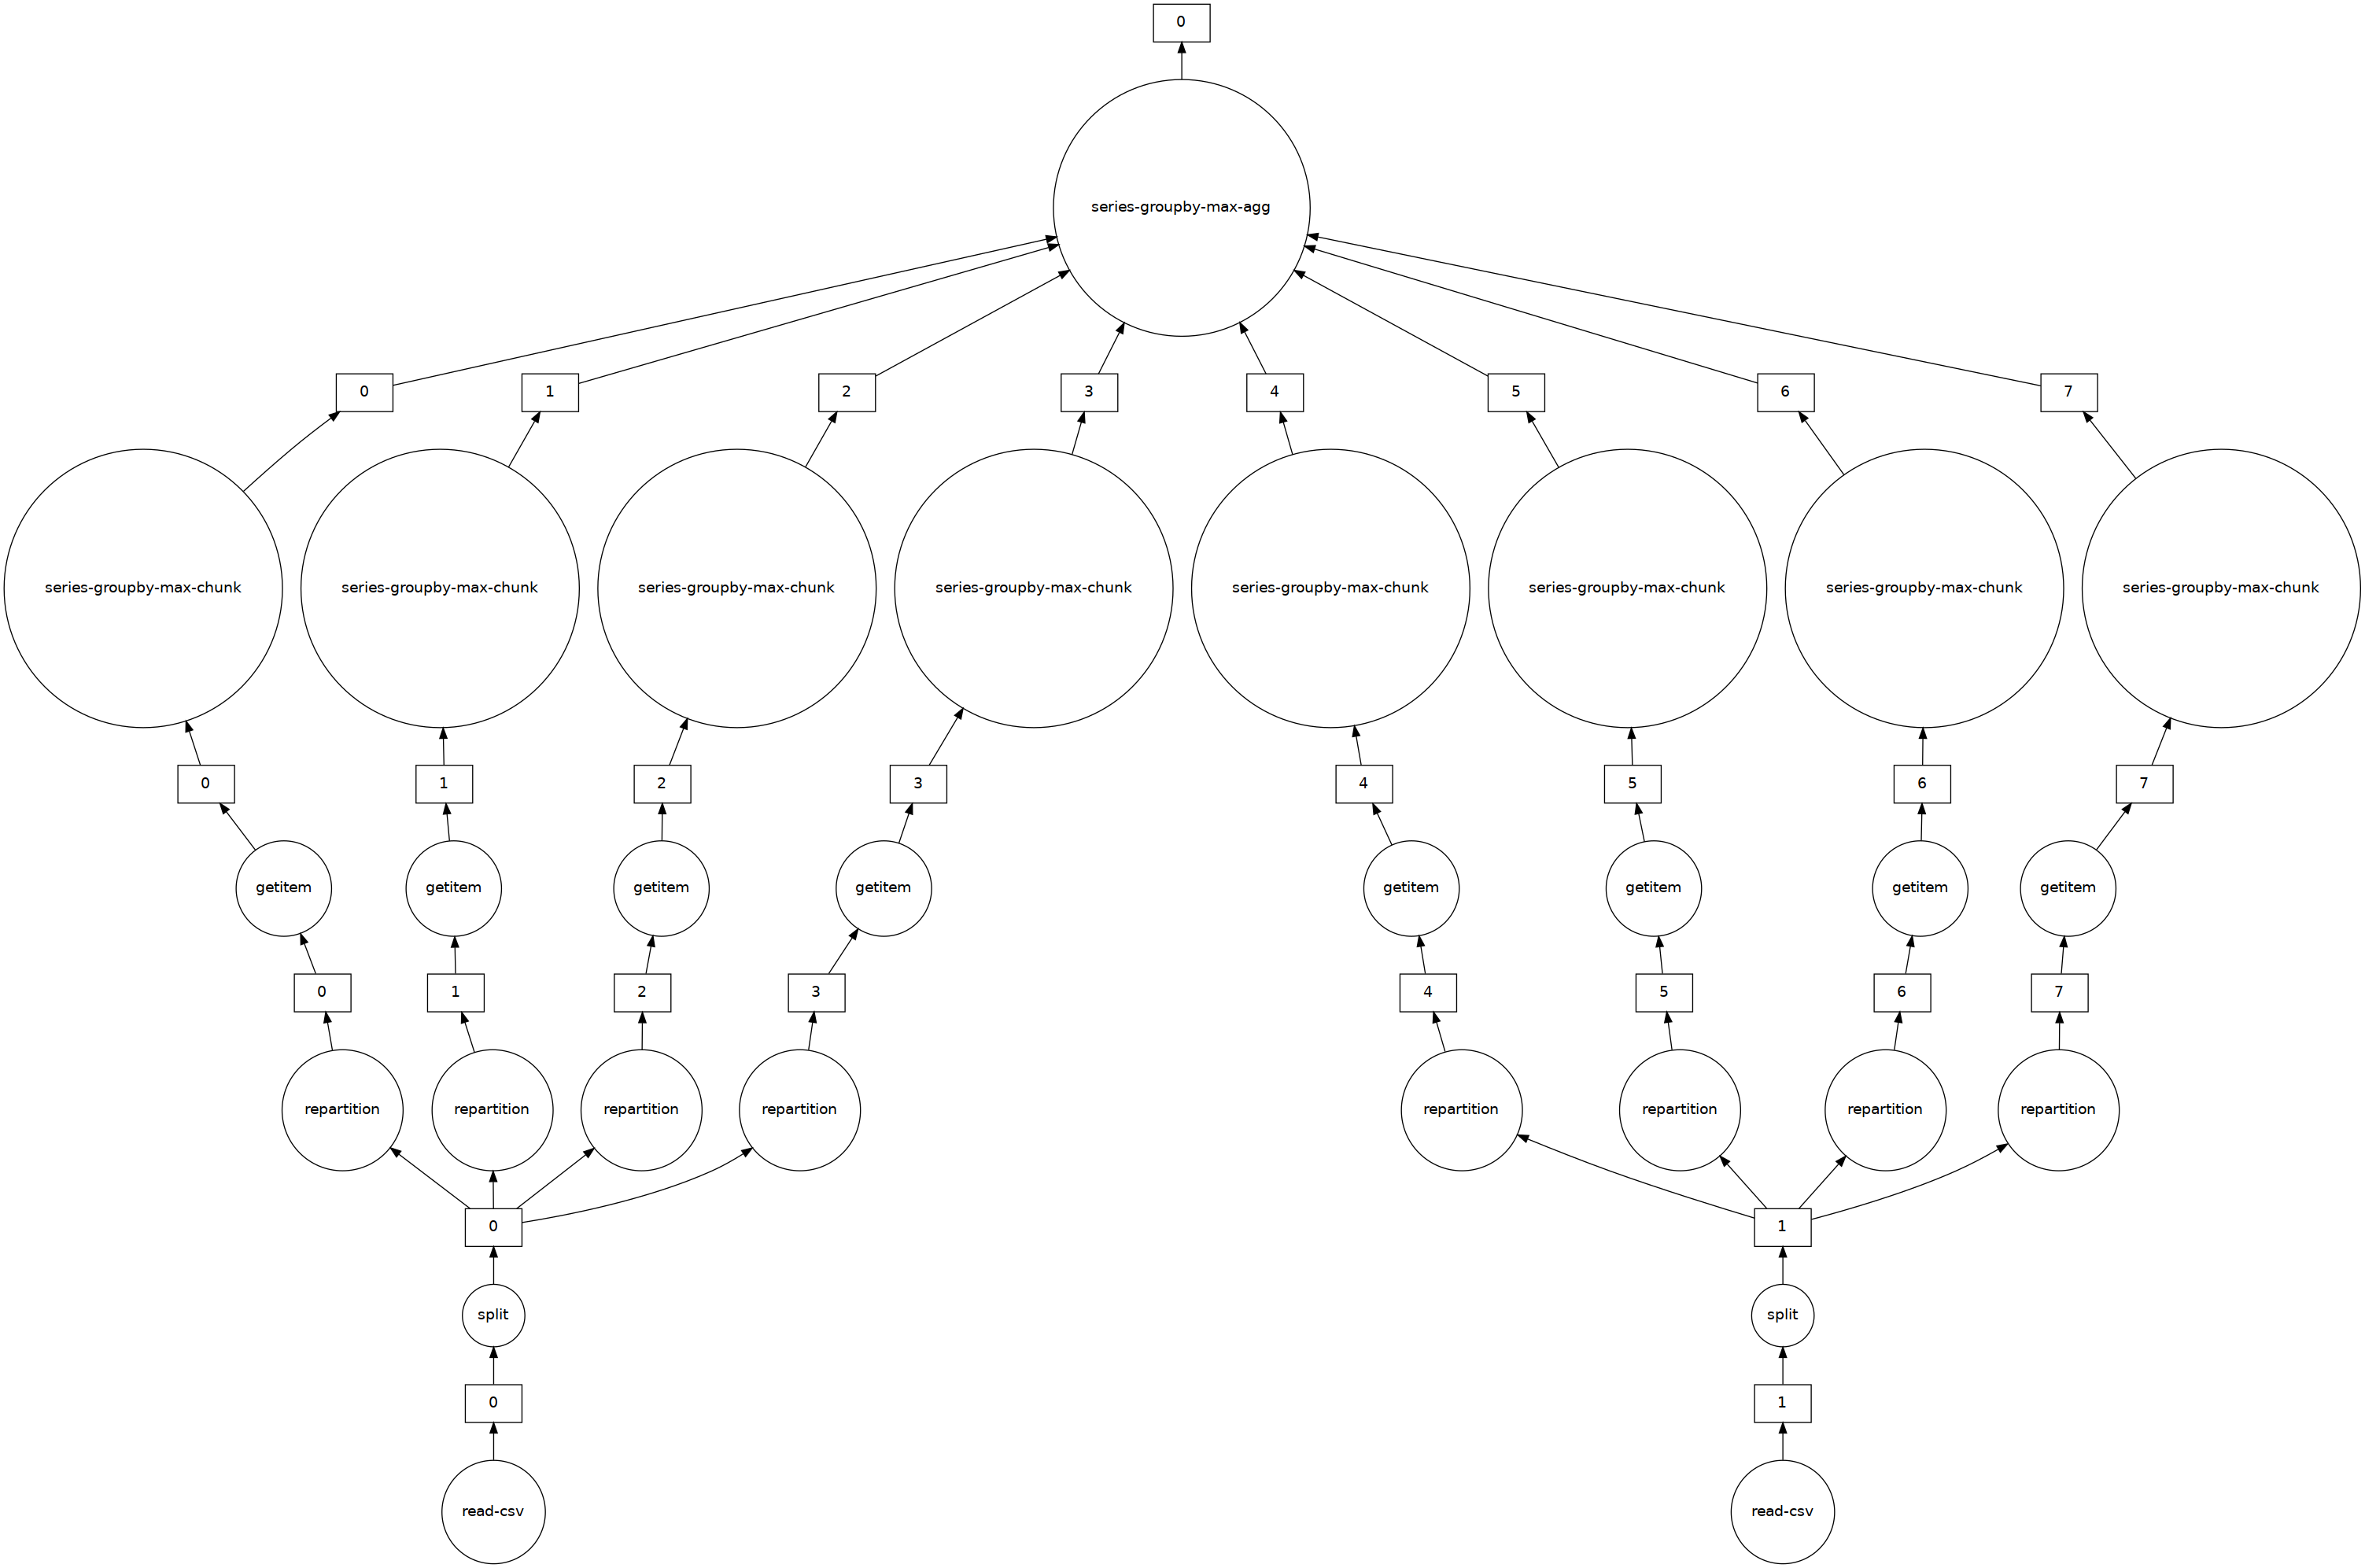

In [27]:
# visualize the graph for this last operation
df.groupby(['Origin', 'Dest']).AirTime.max().visualize()

As we can see from the graph, the `groupby` method returns a single object from the computation, stored in a single partition. This is generally a reasonable choice, as the result of a groupby aggregation is typically small enough to fit into a single worker's memory, eliminating the need to split the result into multiple partitions.

However, there may be cases where the returned object is very large, depending on the input datasets. In such situations, we can optimize the number of output partitions by using the `split_out` argument.

/opt/conda/lib/python3.9/site-packages/dask/dataframe/groupby.py:1540: FutureWarning: In the future, `sort` for groupby operations will default to `True` to match the behavior of pandas. However, `sort=True` does not work with `split_out>1`. To retain the current behavior for multiple output partitions, set `sort=False`.
  warnings.warn(SORT_SPLIT_OUT_WARNING, FutureWarning)


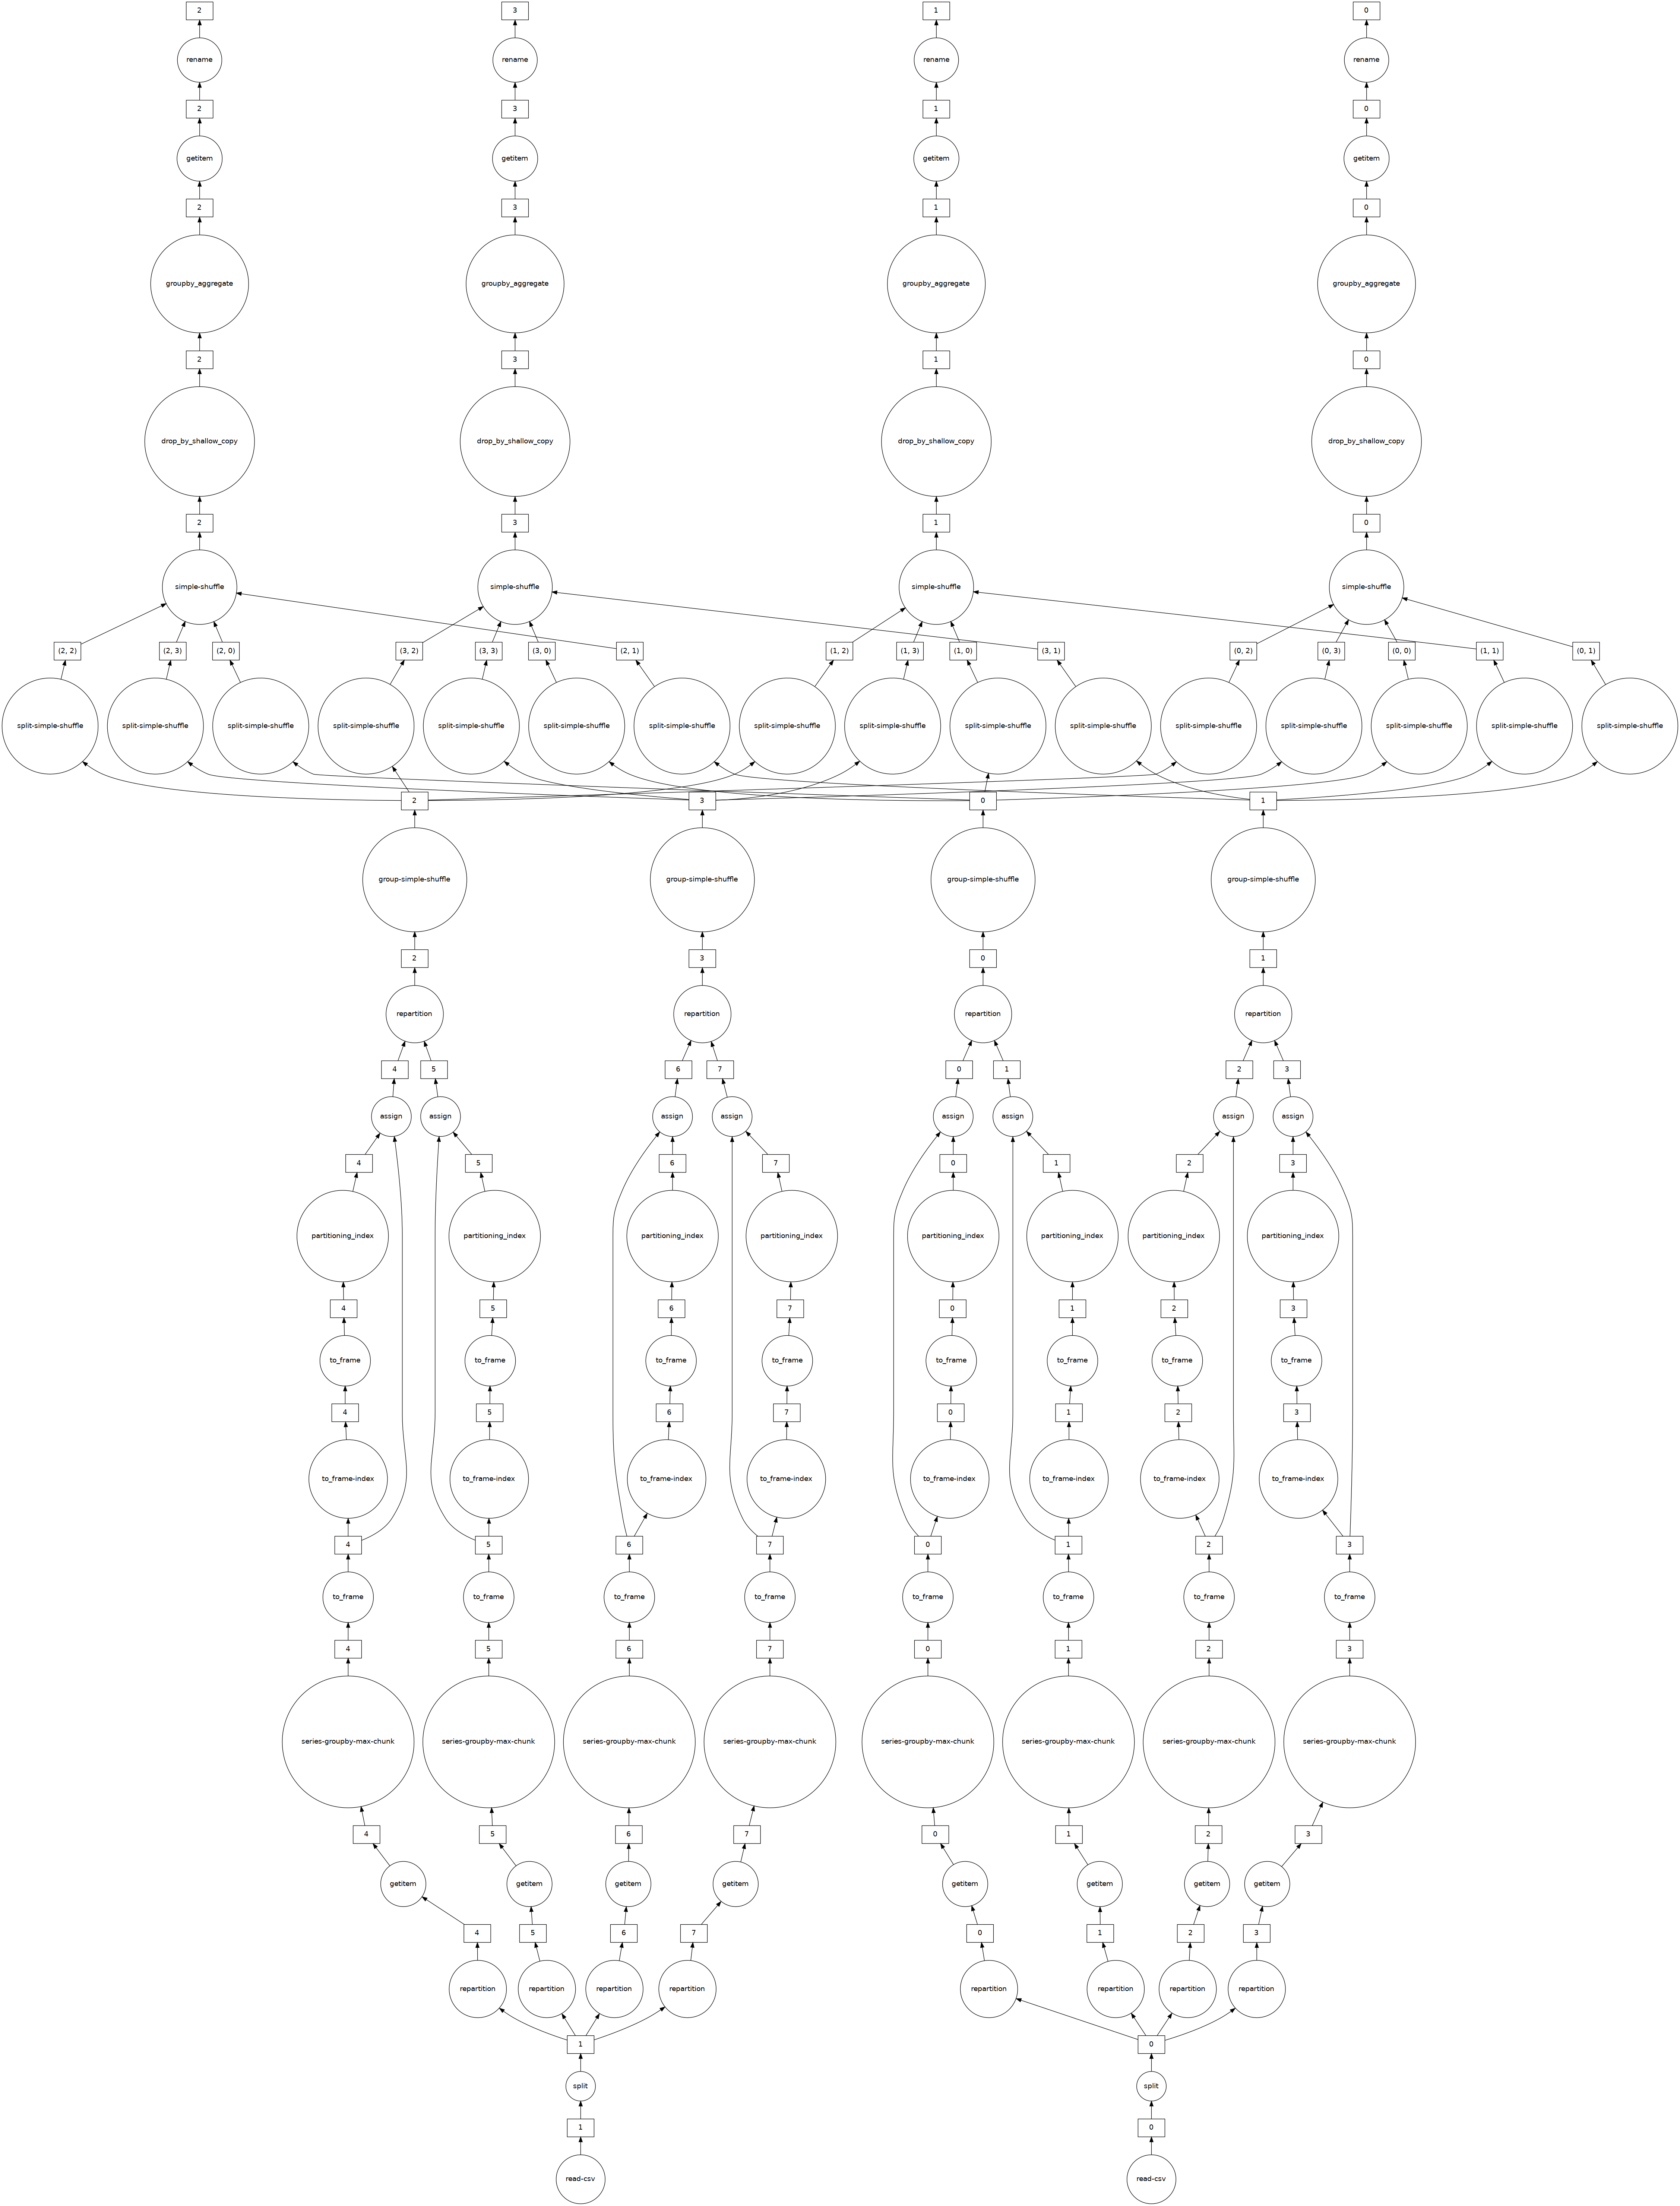

In [28]:
# find the max airtime by combinations of origin and destination
# split the result of the groupby operation in 4 partitions
df.groupby(['Origin','Dest']).AirTime.max(split_out=4).visualize()

Note: Dask also supports the same aggregate syntax as Pandas, allowing us to run several aggregations simultaneously on the same group.

In [29]:
# group the DataFrame by 'Origin' AND 'Dest', and calculate the mean AND standard deviation of 'AirTime'
df.groupby(['Origin', 'Dest'])['AirTime'].aggregate(['mean', 'std']).compute()

mean        std
Origin Dest                       
EWR    BUF    47.991640   3.940099
LGA    SYR    39.000000   3.306014
EWR    BOS    40.255256   7.425724
LGA    GSP    93.606618   7.645009
       FLL   148.742586  10.865923
...                 ...        ...
EWR    BHM   120.321429   8.365754
       SJC   339.879365  14.441339
LGA    LWB    67.974359   5.219778
EWR    SAV   107.785714   6.715981
       TUS   279.500000  24.748737

[175 rows x 2 columns]

There are **certain operations** for which the **mapping with the standard Pandas APIs does not hold** in Dask.

For example, slicing and feature-based indexing using `loc` work as expected in Dask, but the position-based indexing operator `iloc` does not behave the same way as it does in Pandas.

In [30]:
# select rows where 'Dest' column equals 'DEN' and retrieve the 'UniqueCarrier' column
df.loc[df['Dest'] == 'DEN', ['UniqueCarrier']].compute()

UniqueCarrier
7081              TW
7082              TW
7083              TW
7084              TW
7085              TW
...              ...
269176            UA
269177            UA
269178            UA
269179            UA
269180            UA

[13581 rows x 1 columns]

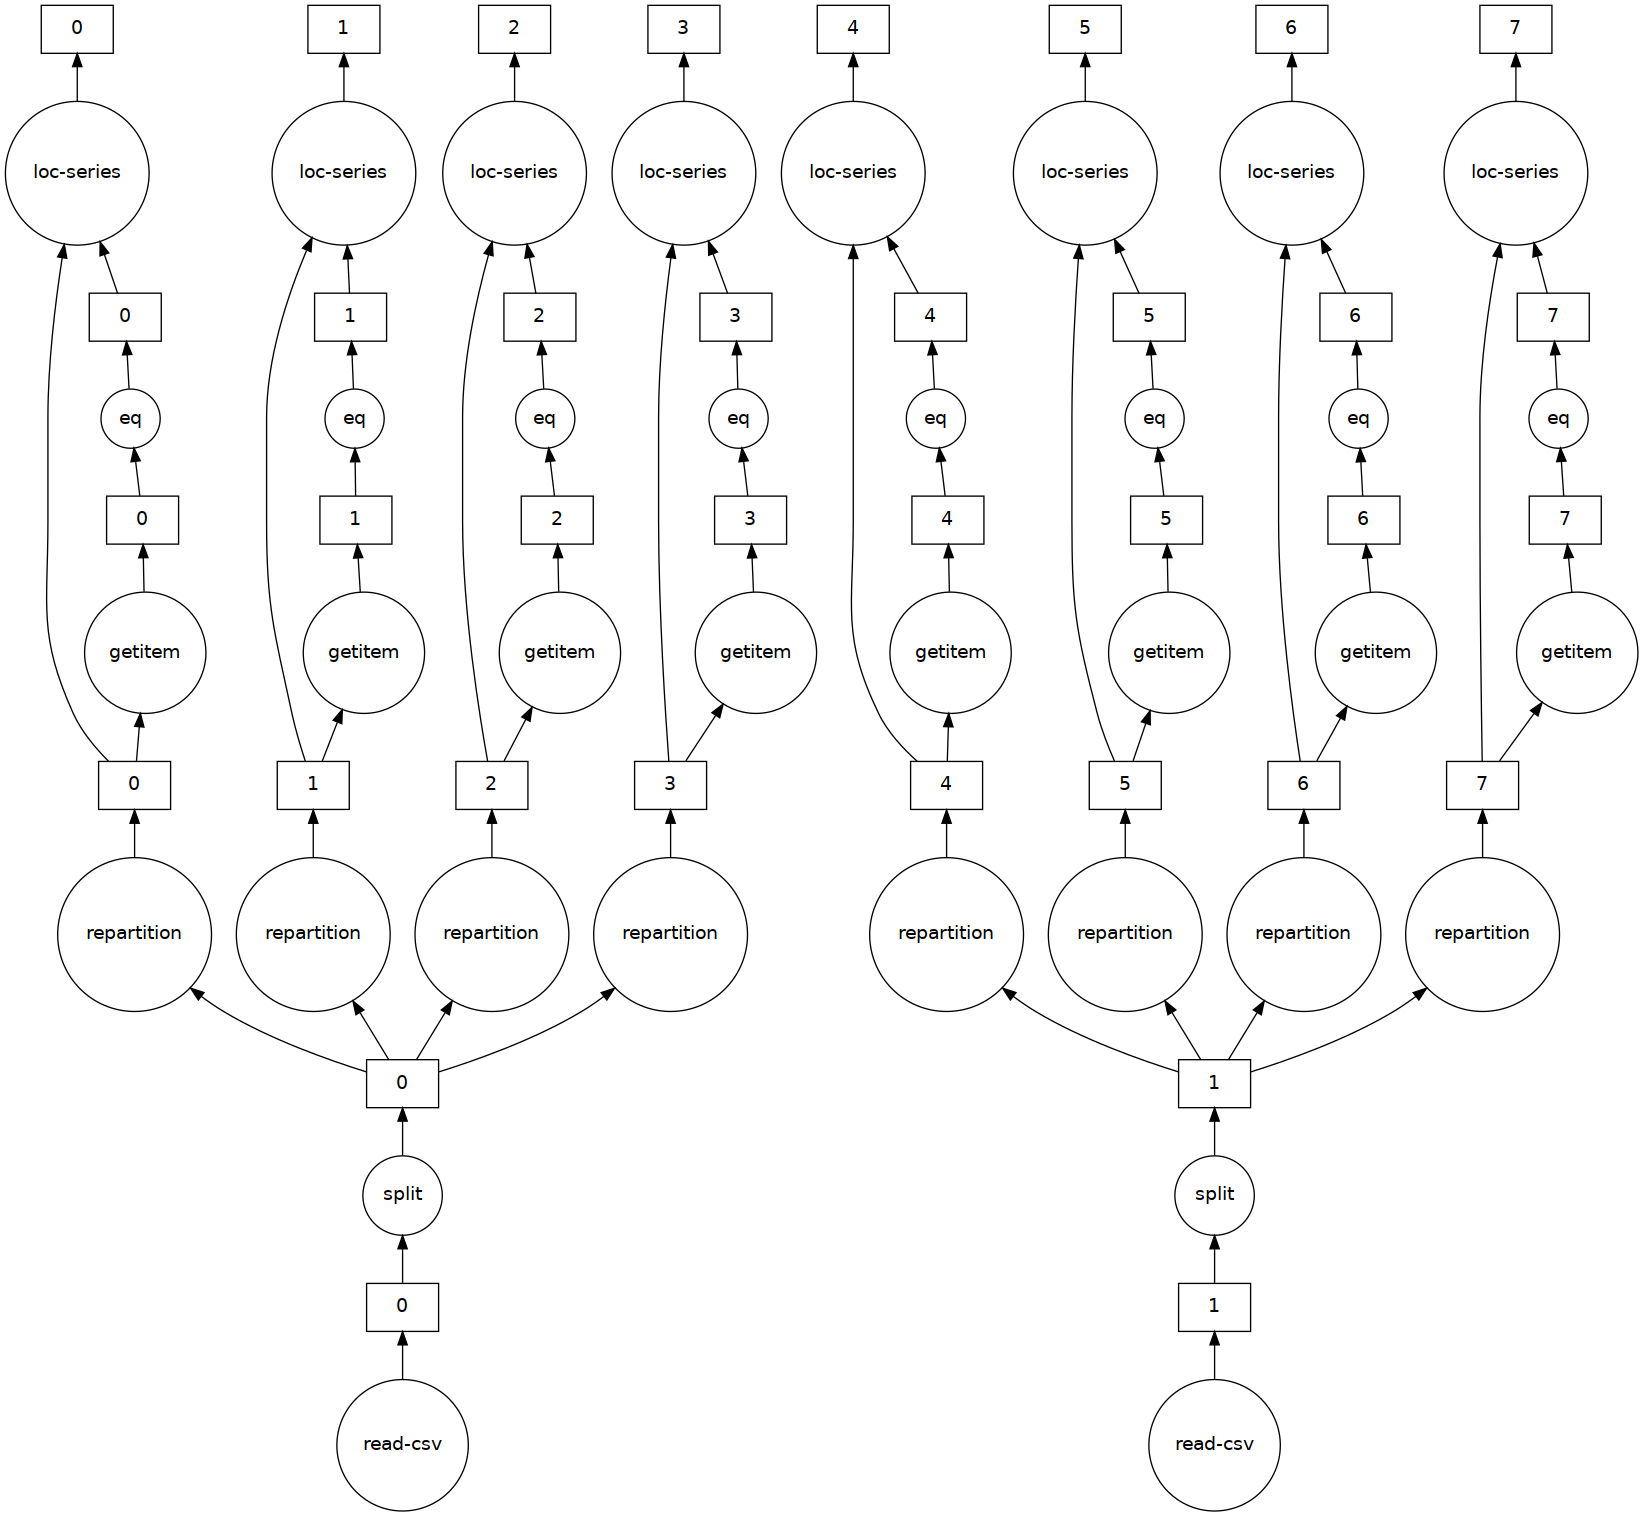

In [31]:
# visualize the graph for this last operation
df.loc[df['Dest']=='DEN',['UniqueCarrier']].visualize()

In Dask, using `iloc` for position-based indexing will raise an exception instead of behaving as it does in Pandas.

In [32]:
# use iloc to locate the first i-th rows of the *distributed* DataFrame
df.iloc[0:10]

NotImplementedError: 'DataFrame.iloc' only supports selecting columns. It must be used like 'df.iloc[:, column_indexer]'.

This behavior occurs because Dask DataFrame does not consider the length of partitions or the row ordering within each partition. When records are sharded across multiple nodes, determining the true ordering of rows becomes ambiguous.

While you can still use `iloc` to select the index of a specific column for all rows in all partitions, such as `iloc[:, 0:10]`, it is important to note that `iloc` can be extremely inefficient in Dask due to the underlying data distribution and lack of explicit row ordering.

Other operations that are **inefficient** in Dask include actions that require _re-indexing_ of the entire DataFrame, _sorting_, or _merging based on a column that is not the DataFrame's index_.

Dask optimizes the data distribution by utilizing the range of the index column to subdivide the data into partitions. However, setting an index on a DataFrame requires sorting the entire dataset by the specified column, which can be an expensive process. While sorting can be slow, it can be beneficial to perform it (although infrequently) to accelerate subsequent computations.

Dask also leverages the index in merge/join operations. Performing a join on a column that is not the DataFrame's index is also an expensive operation.

After performing an unavoidable and expensive operation such as reshuffling the data, you can persist the new DataFrame to speed up subsequent computations.

In [33]:
# select rows where 'UniqueCarrier' is 'UA' and 'Dest' is 'DEN', and set the index to 'Date'
df_reindexed = df[(df.UniqueCarrier=='UA') & (df['Dest']=='DEN')].set_index('Date')

In [34]:
# compute a 5-days rolling average of the related ArrivalDelay
df_reindexed.ArrDelay.rolling('5D').mean().compute()

Date
1993-01-01    11.000000
1993-01-01    11.500000
1993-01-01    14.000000
1993-01-01    14.500000
1993-01-01    13.800000
                ...    
1999-12-31    -7.283019
1999-12-31    -7.388889
1999-12-31    -7.163636
1999-12-31    -7.500000
1999-12-31    -7.543860
Name: ArrDelay, Length: 7850, dtype: float64

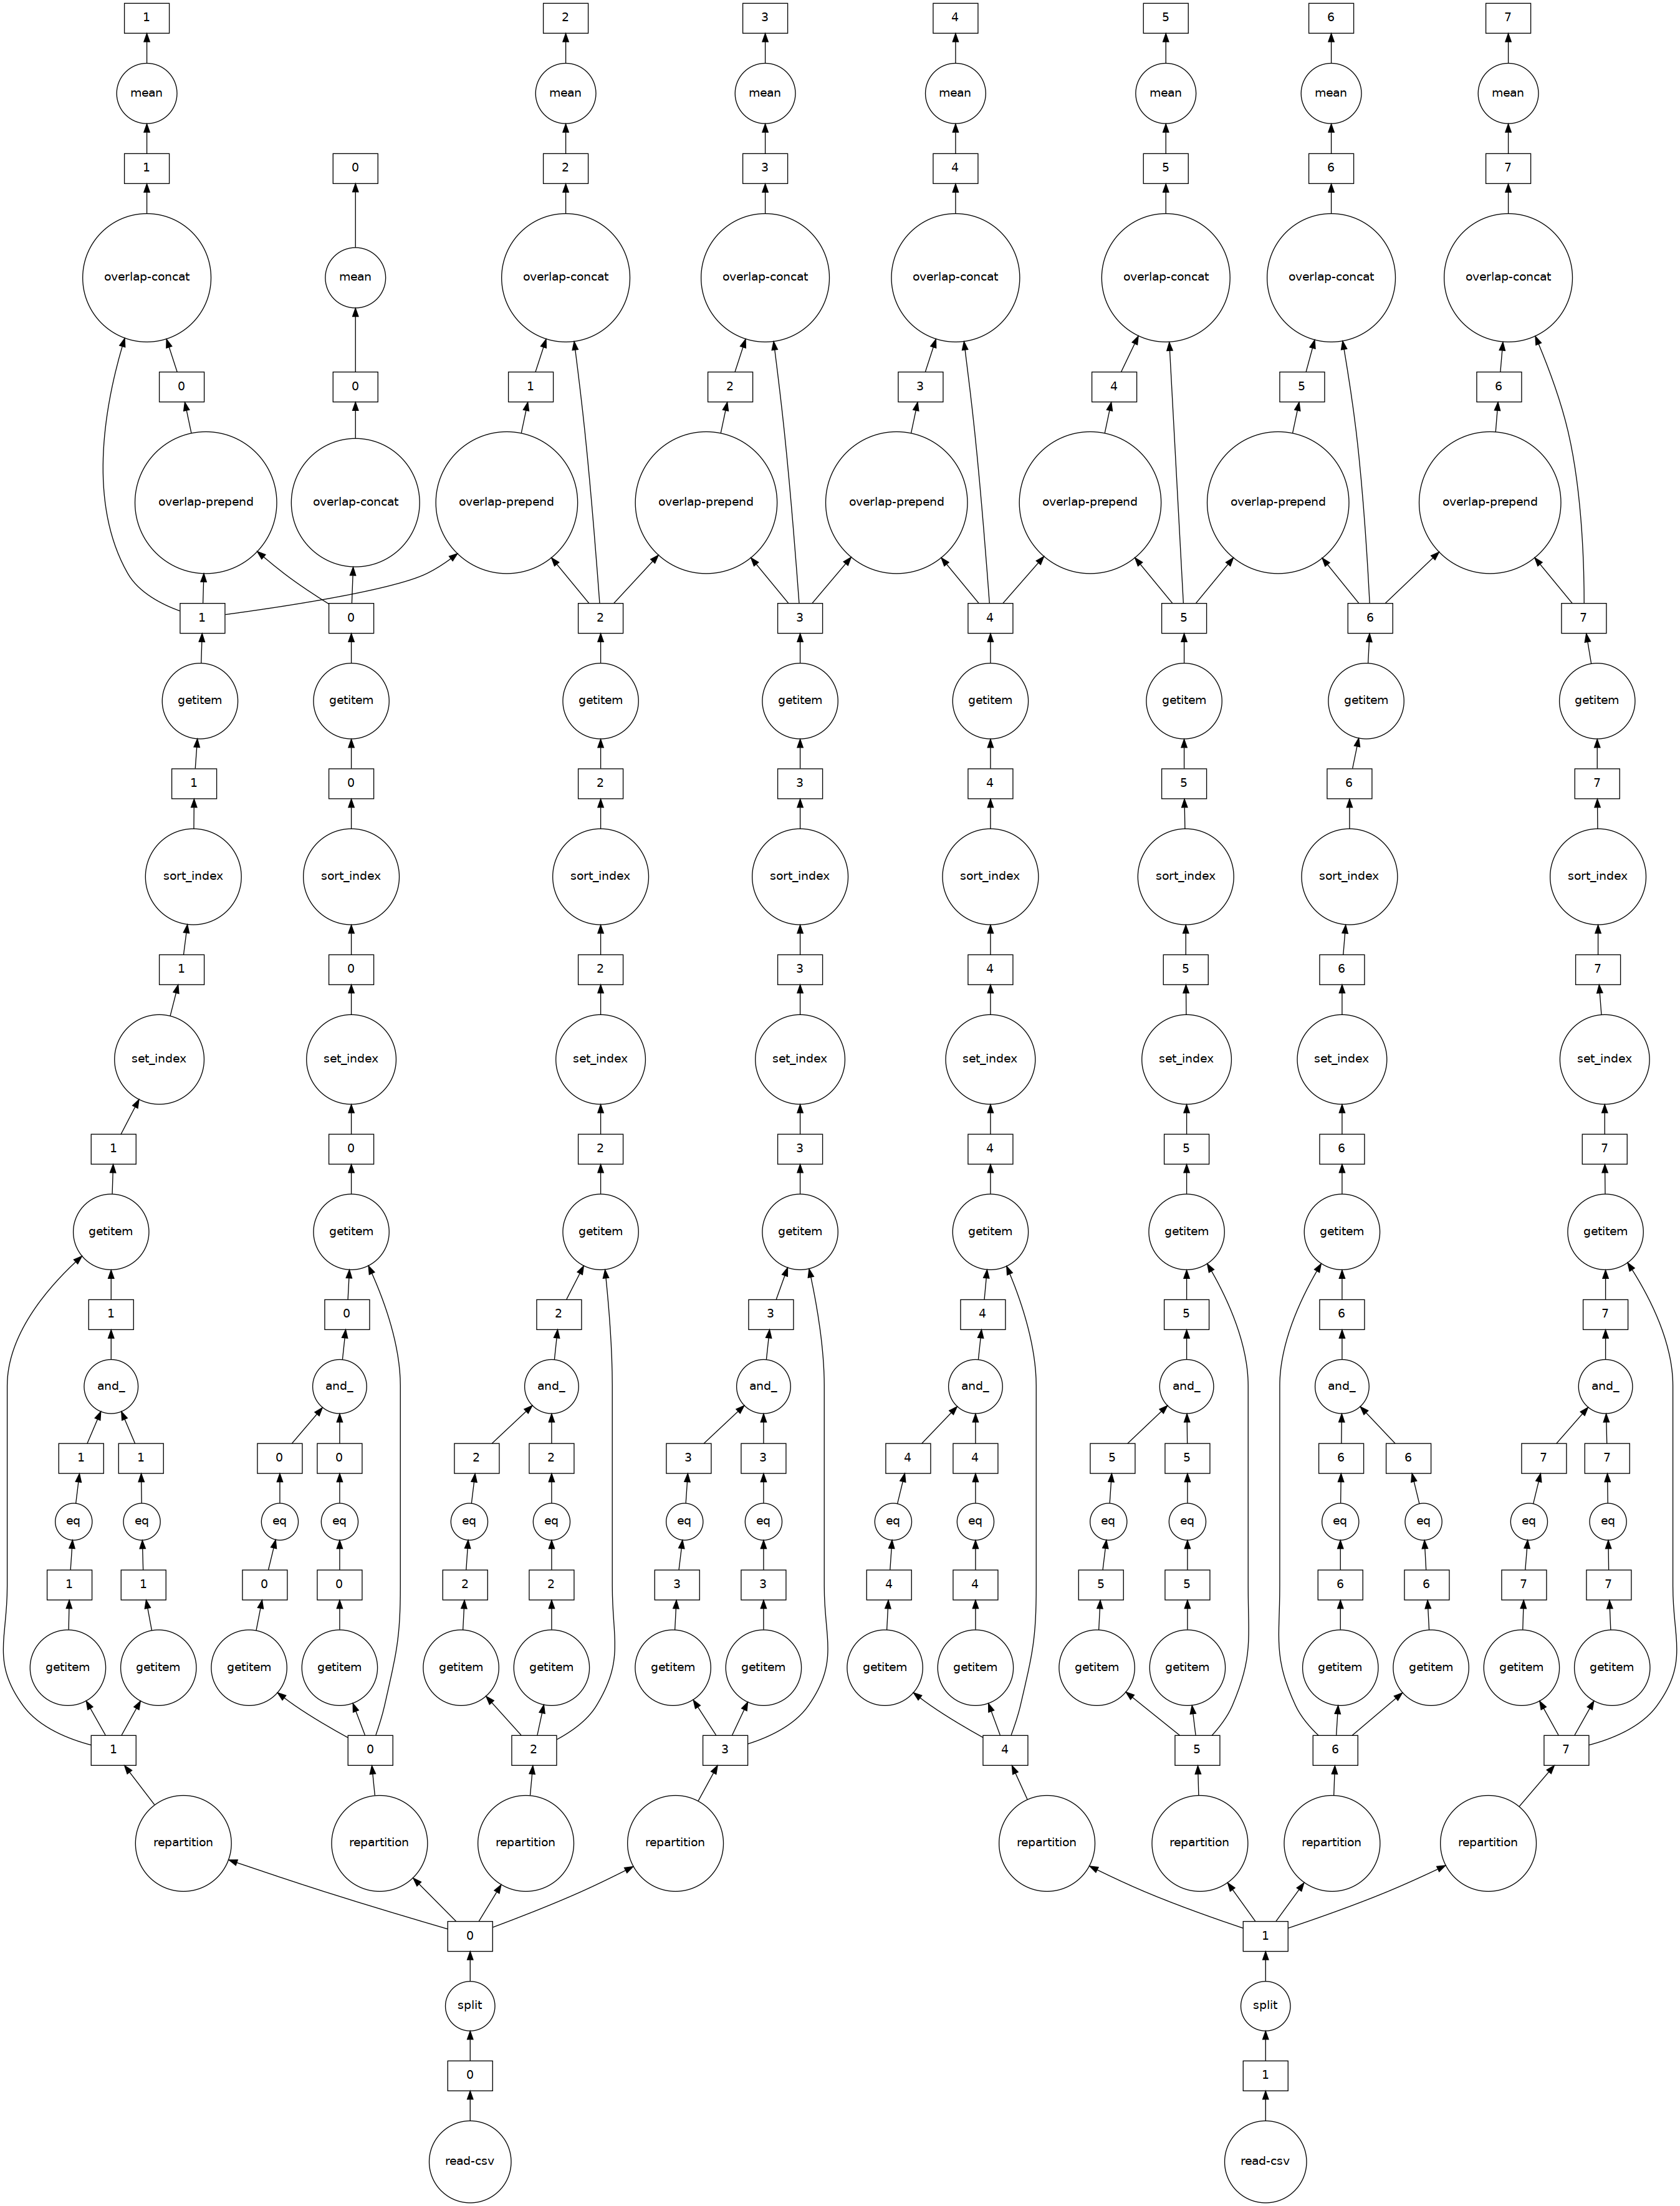

In [35]:
# visualize the graph for this last operation
df_reindexed.ArrDelay.rolling('5D').mean().visualize()

## Shared, reapeated and intermediate computations

When performing the computations mentioned above, there may be cases where the same operation needs to be repeated multiple times. 

In Dask DataFrame, for most operations, the arguments are hashed, allowing for duplicate computations to be shared and computed only once.

For example, let's consider computing the mean and standard deviation of departure delay for all non-canceled flights. Since Dask operations are lazy, the computed values are not the final results yet. They represent the recipe required to obtain the final result.

If we change the approach and compute these values with two individual calls to `compute`, there will be no sharing of intermediate computations, resulting in an overall speedup of the computation.

In [36]:
# cache the distributed DataFrame in the memory of the workers
df = df.persist()

In [37]:
# show the head of the DataFrame
df.head()

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
0 1993-01-29          5   1055.0        1055   1228.0        1212   
1 1993-01-30          6   1052.0        1055   1214.0        1212   
2 1993-01-31          7   1103.0        1055   1213.0        1212   
3 1993-01-03          7   1736.0        1729   1838.0        1831   
4 1993-01-04          1   1730.0        1729   1825.0        1831   

  UniqueCarrier  FlightNum TailNum  ActualElapsedTime  ...  AirTime  ArrDelay  \
0            US         66     NaN               93.0  ...      NaN      16.0   
1            US         66     NaN               82.0  ...      NaN       2.0   
2            US         66     NaN               70.0  ...      NaN       1.0   
3            US         70     NaN               62.0  ...      NaN       7.0   
4            US         70     NaN               55.0  ...      NaN      -6.0   

   DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  Diverted  
0       0.0     EWR  BUF    282.0     NaN      NaN          0         0  
1      -3.0     EWR  BUF    282.0     NaN      NaN          0         0  
2       8.0     EWR  BUF    282.0     NaN      NaN          0         0  
3       7.0     LGA  SYR    198.0     NaN      NaN          0         0  
4       1.0     LGA  SYR    198.0     NaN      NaN          0         0  

[5 rows x 21 columns]

In [38]:
import dask

# create non-cancelled dataframe (lazy)
non_cancelled = df[df.Cancelled==0]

# create mean DepDelay series (lazy)
mean_delay    = non_cancelled.DepDelay.mean()

# create std DepDelay series (lazy)
std_delay     = non_cancelled.DepDelay.std()

In [39]:
%%time

# compute the time to run both functions
mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 40.3 ms, sys: 2.36 ms, total: 42.6 ms
Wall time: 271 ms


In [40]:
%%time

# compute the time to combining both functions into a single compute call
mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 25.8 ms, sys: 1.41 ms, total: 27.2 ms
Wall time: 190 ms


Using `dask.compute` takes approximately half the time compared to the other approach. This is because when calling `dask.compute`, the task graphs for both results are merged, allowing shared operations to be performed only once instead of twice. Specifically, `dask.compute` performs the following operations once:

- Calls to the `read_csv` function
- Filter on cancelled flights
- Some necessary reductions (such as sum and count)

Let's take a look at the computation graph:

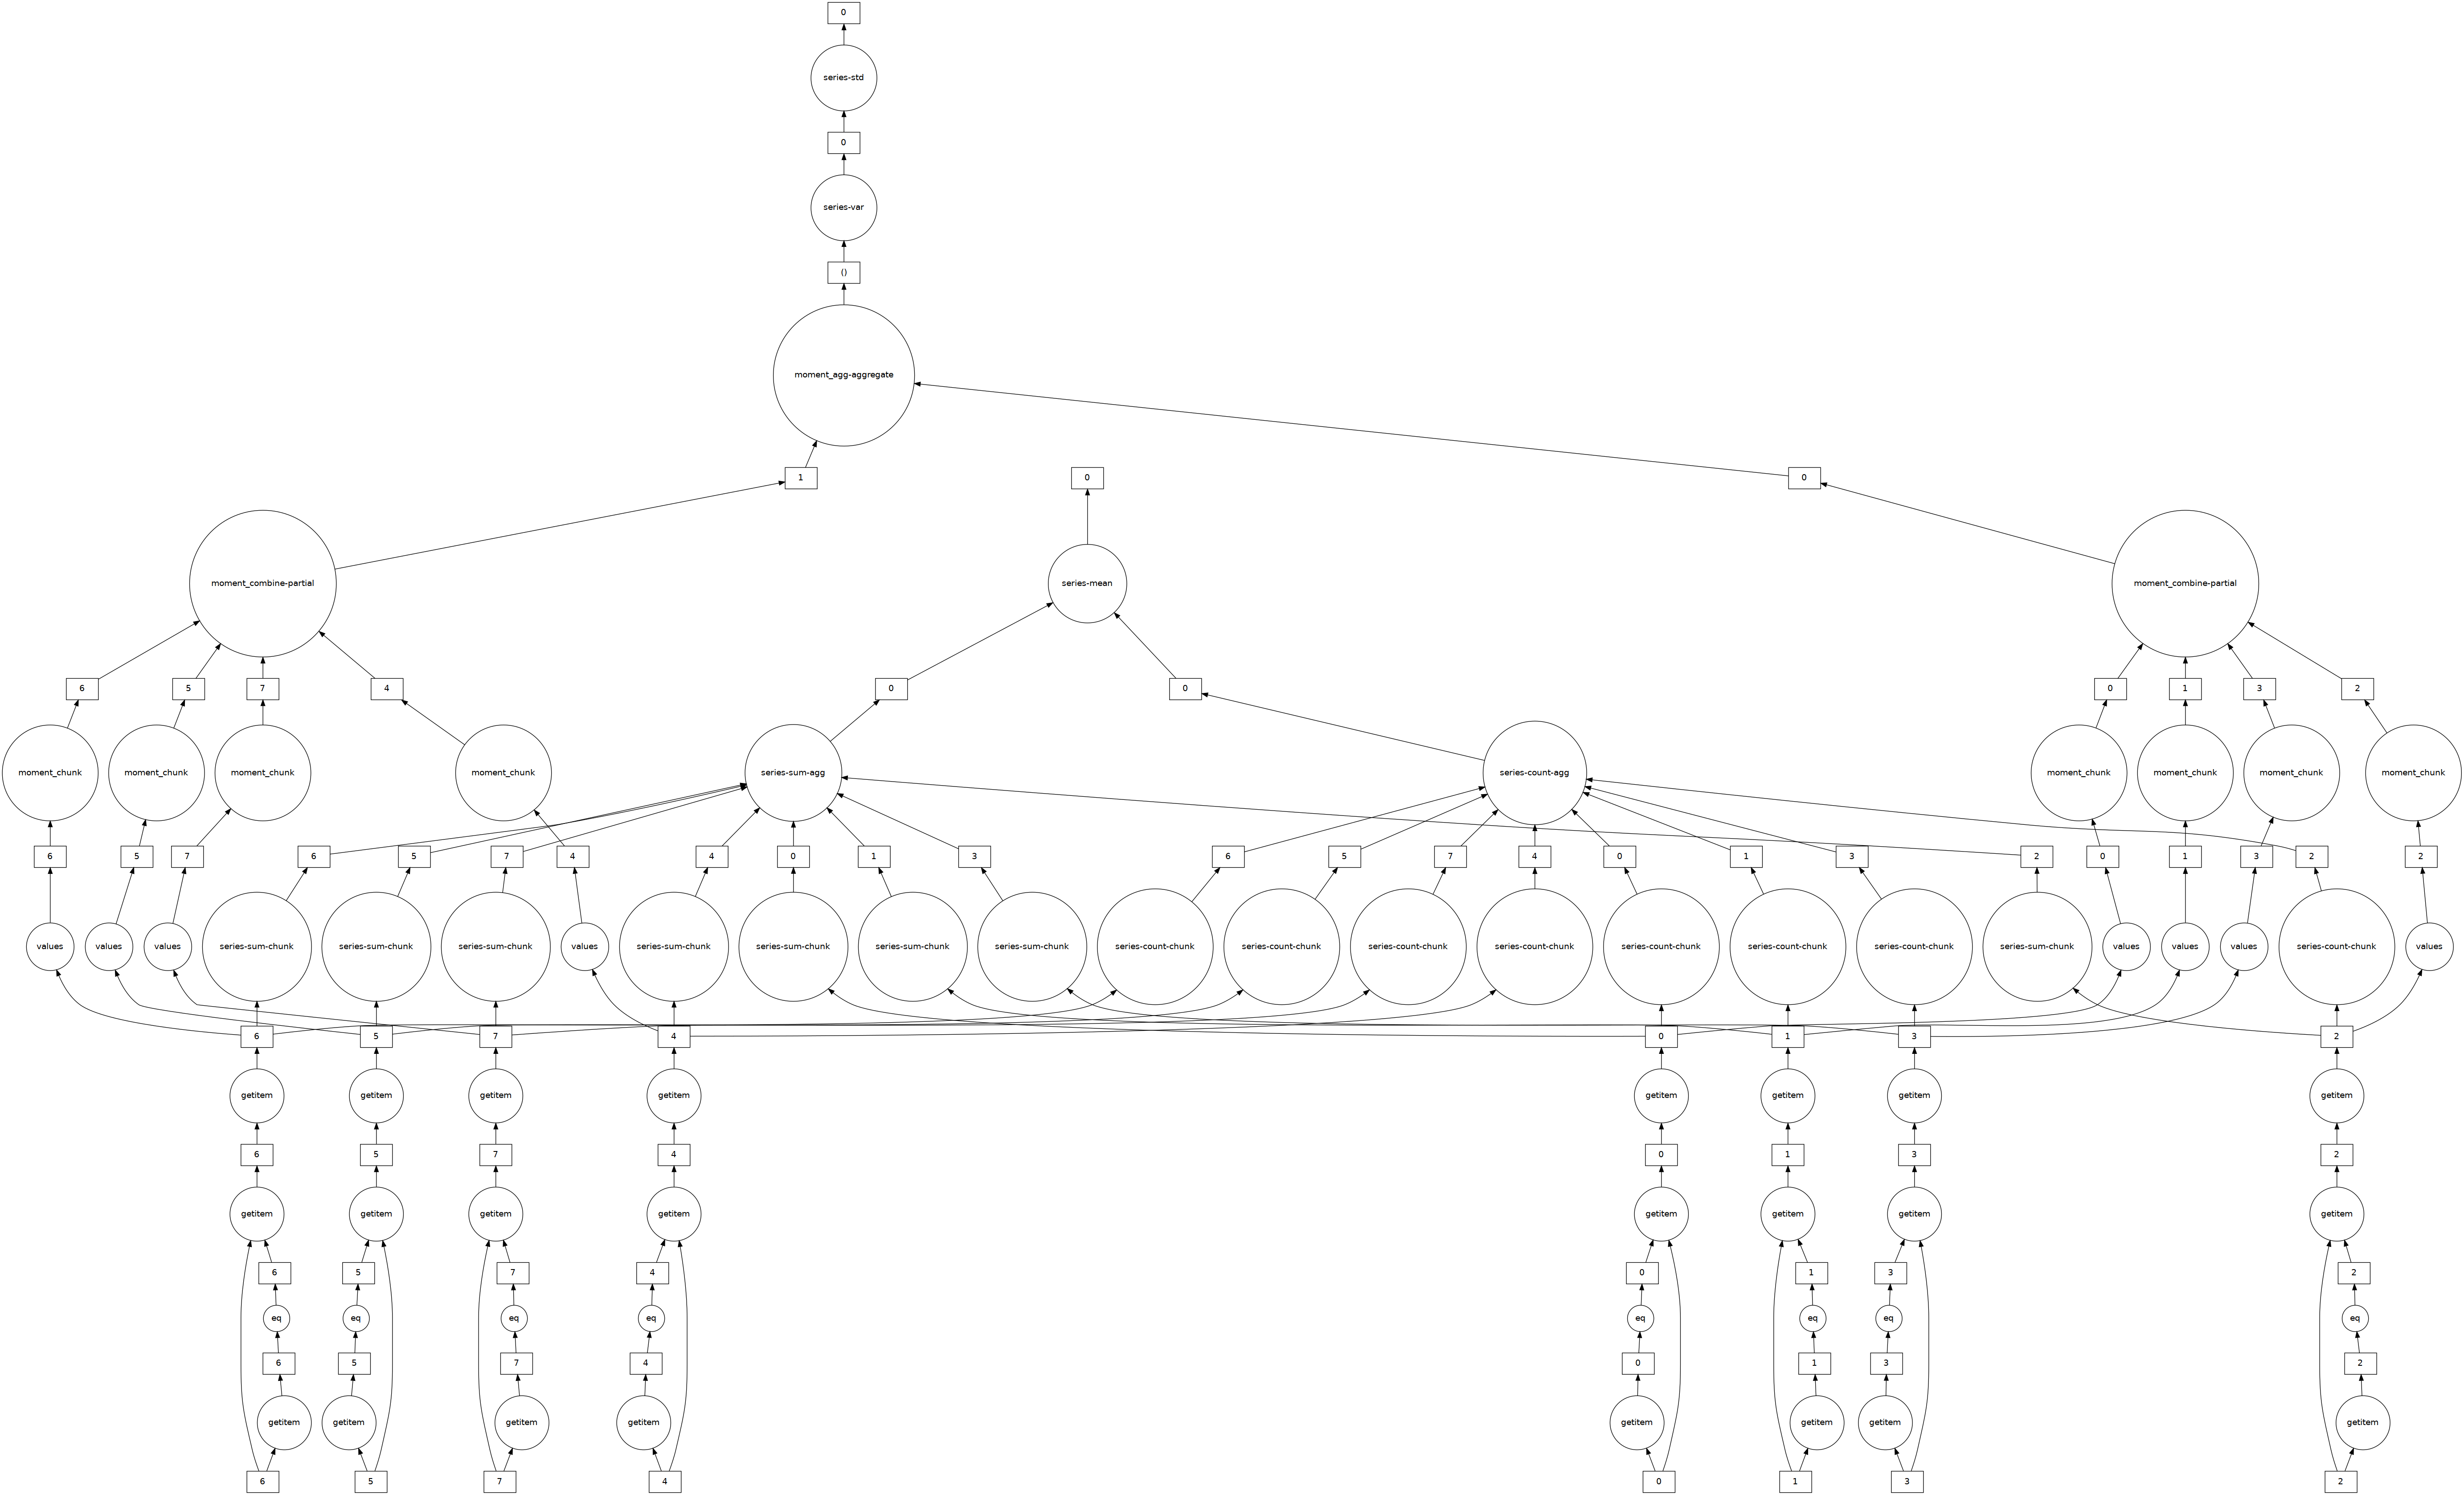

In [41]:
# visualize the graph and spot the two outputs
dask.visualize(mean_delay, std_delay)

What we can observe from the computation graph is that many operations have been merged and used only once, resulting in an optimization of the overall computation time.

## Re-run the same exercise from the Spark notebook using Dask

To apply all we discussed about Dask high- and low-level APIs, we can re-run the same task we used as an example analysis pipeline in PySpark for the DiMuon invariant mass of the LHC collision data.

Starting from the JSON files already used in the previous PySpark example, we will need to:
1. Load all files using the Dask Bag API.
2. Parse the JSON event collections into Python dictionaries.
3. Use a `foldby` operation to count the number of events per sample (mc and data).
4. Plot the distribution of the number of muons in the MC and data samples from the Dask Bag object.
5. Select only events with exactly 2 muons with opposite charge and fill a Dask DataFrame with the normalized results.
6. Create the transverse momenta $p_{T,1}$ and $p_{T,2}$ features and create a 2D plot of these features.
$$p_T = \sqrt{p_x^2 + p_y^2}$$
7. Retain only the dimuon pairs where both muons' $p_T$ is greater than 15 (GeV).
8. Create the components of the dimuon 4-momentum
$$(E,P_x,P_y,P_z) = (E_1+E_2,p_{x,1}+p_{x,2},p_{y,1}+p_{y,2},p_{z,1}+p_{z,2})$$
9. create and plot the invariant mass spectrum
$$M = \sqrt{E^2 - (P_x^2 + P_y^2 + P_z^2) }$$


Before starting, from a terminal (external to the docker container you are working in), copy the `MAPD-B/spark/datasets/lecture2/dimuon` folder into the `MAPD-B/dask/notebooks/datasets/.` path, or create a symbolic link to that path.

In [ ]:
# restart the client to free up the workers' memory
client.restart()

In [ ]:
# load the dimuon json files in a bag, each containing the text lines


In [ ]:
# extract the json structure from the lines


In [ ]:
# count the number of events per each sample


In [ ]:
# plot the distribution of the number of muons in the mc and data sample


In [ ]:
# select only events with exactly 2 muons with opposite charge and fill a dask dataframe with the results


In [ ]:
# create the new pT1 and pT2 features 
# pT = sqrt(px^2 + py^2)


In [ ]:
# plot the 2 dimensional distribution of the dimuon pair pTs in the mc sample


In [ ]:
# retain only those dimuon pairs where both muons' pT is greater than 15 


In [ ]:
# create the 4-momentum features 

# and compute the invariant mass of the dimuon pair
# M = sqrt(E*E - (Px*Px + Py*Py + Pz*Pz))


In [ ]:
# extract the slimmed down dataframe containing only the sample, Mass, and pT of the objects
# and store it in a Pandas DataFrame


In [ ]:
# plot the distribution of the dimuon invariant mass in the mc and data sample


### (in the case of memory management issues)

In [ ]:
# to reclaim some memory from the workers
import ctypes

# invoke the C library libc.so.6 to deallocate memory from the worker
def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)

# run the `trim_memory` function on all Dask workers to reclaim memory
client.run(trim_memory)

In [ ]:
# restart the client (this will reset all operations done so far)
client.restart()

## Stop client

In [ ]:
client.close()

Finally, use `docker compose down` to stop and clear all running containers.